In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from  av.io import read
import pandas as pd
import datetime
import tensorflow as tf
#tf.enable_eager_execution()


from sklearn.preprocessing import normalize
from tensorflow import keras



In [37]:
use_rotation_sensor = False
use_accelerometer_sensor = True
use_gyroscope_sensor = True
use_magnetic_sensor = True
sensor_inputs = 0
normalize_vector = np.array([])

if use_rotation_sensor:
    sensor_inputs += 5
    normalize_vector = np.append(normalize_vector, [1,1,1,1,1], axis=0)

if use_accelerometer_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [15,15,15], axis=0)
    
if use_gyroscope_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [3,3,3], axis=0)

if use_magnetic_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [40,40,40], axis=0)


cut_shape = (100, sensor_inputs)
gestures = {0: 'Noise', 1: 'Left', 2: 'Right'}

In [38]:
def read_file(filename, lable=None):
    data, meta = read(" ".join(["a:" + str(i) for i in range(4)]), filename, 50)
    datapairs = list(zip(data, meta))
    
    df = pd.DataFrame()
    names = []
    col_name_tpls = []
    for sensor_data, stream_object in datapairs:
        meta_dict = stream_object.metadata
        # print(meta_dict)
        name = meta_dict["NAME"]
        names.append(name)
        n_cols = len(sensor_data)
        col_names = []
        for i in range(n_cols):
            col_name = name + "_" + str(i)
            col_names.append(col_name)
            df[col_name] = pd.Series(sensor_data.T[:,i])
        col_name_tpls.append(col_names)
    df.index = pd.TimedeltaIndex(freq="20ms", start=0.0, periods=len(df))
    return df, col_name_tpls

def trim_data(data_frame, start=0.0, end=None):
    if end:
        df = data_frame[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = data_frame[pd.Timedelta(10**9 * start):]
    return df

def cut_data(data_frame, cuts):
    df_cut_list = np.ndarray(shape=(len(cuts),) + cut_shape)
    for i, cut in enumerate(cuts):
        df_i = data_frame[pd.Timedelta(10**9 * cut[0]):pd.Timedelta(10**9 * cut[1])]
        prev_sensor_channels = 0
        if use_rotation_sensor:
            df_cut_list[i, : , 0:5] = df_i.iloc[0: 100, 0:5]
            prev_sensor_channels += 5
        if use_accelerometer_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 5:8]
            prev_sensor_channels += 3
        if use_gyroscope_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 8:11]
            prev_sensor_channels += 3
        if use_magnetic_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 11:14]
            prev_sensor_channels += 3
    return df_cut_list


def find_peaks(df, sensor, start=0.0, end=None, sel_method="right"):
    peaks = []
    if end:
        df = df[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = df[pd.Timedelta(10**9 * start):]

    for i in df.index:
        value = df[sensor][i]
        if sel_method == "right":
            cond = value > 8
        elif sel_method == "left":
            cond = value < -1
        if cond:
            new = True
            for peak in peaks:
                if i - pd.Timedelta(10**9) < peak + pd.Timedelta(10**9):
                    new = False
                    break
            if new:
                peaks.append(i)
    cuts = []
    for peak in peaks:
        t = peak.value / 10 ** 9
        cuts.append((t-1, t+1))
    return cuts 

def normalize_cuts(cuts):
    for i in range(len(cuts)):
        cuts[i, : , :] = cuts[i]/normalize_vector
    return cuts
  

def plot_dataframe(df, col_name_tpls):
    for col_name_tpl in col_name_tpls:
        for col_name in col_name_tpl:
            fig = df[col_name].plot()
            fig.set_title(col_name)
            plt.show()

def plot_cuts(cuts, sensor=None):
    if sensor is None:
        for cut in cuts:
            plt.plot(cut)
            plt.show()
        return
    for cut in cuts:
        cut = cut[sensor]
        cut = cut.values.reshape(-1,1)
        print(cut.shape)
        normed_matrix = normalize(cut, axis=0, norm='l1')
        plt.plot(normed_matrix)
        plt.show()

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


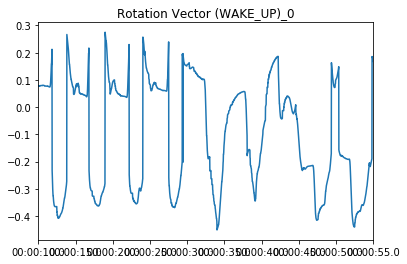

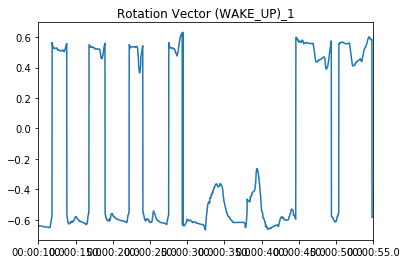

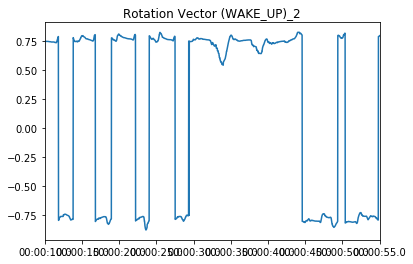

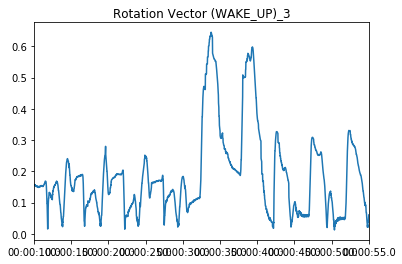

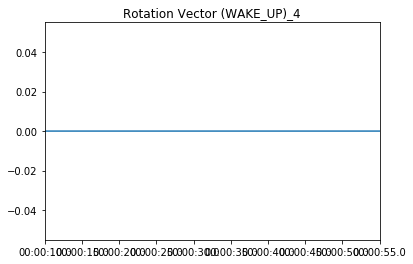

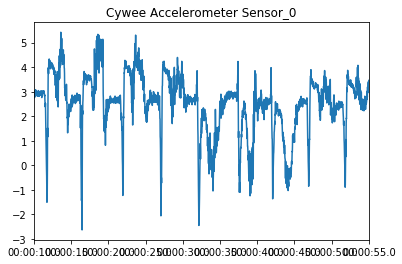

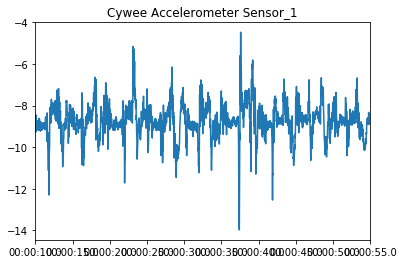

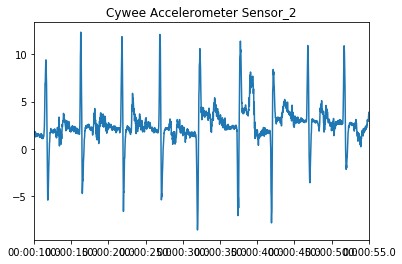

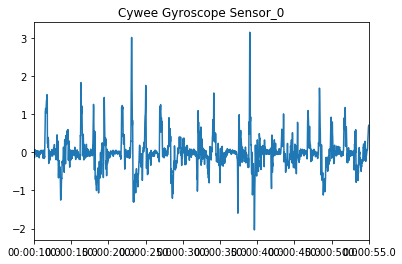

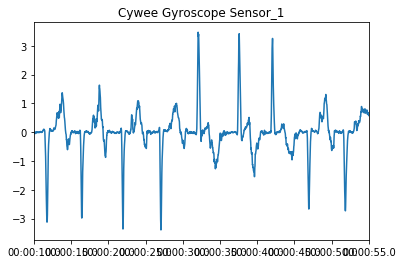

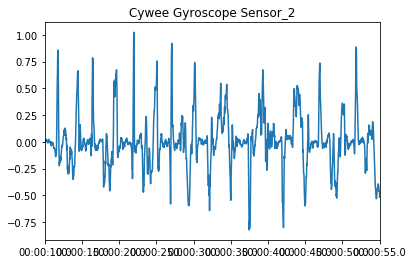

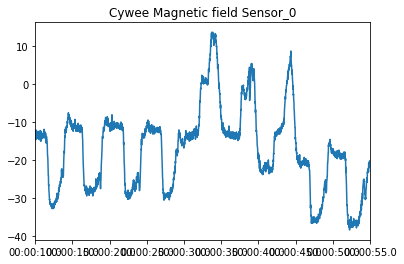

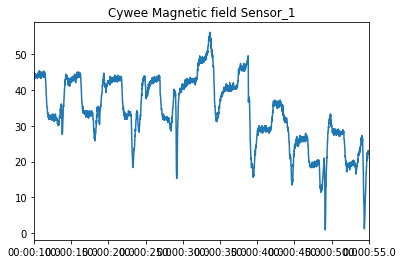

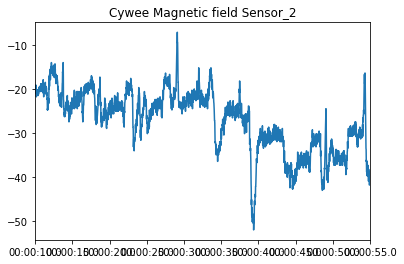

9 : [(10.54, 12.54), (15.239999999999998, 17.24), (20.76, 22.76), (25.86, 27.86), (31.22, 33.22), (36.64, 38.64), (41.14, 43.14), (45.74, 47.74), (50.64, 52.64)]
Found cuts: 9


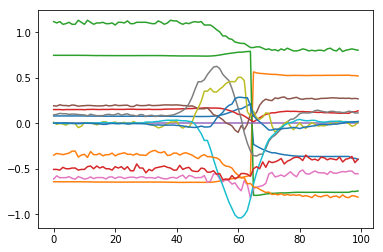

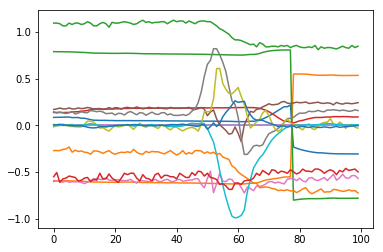

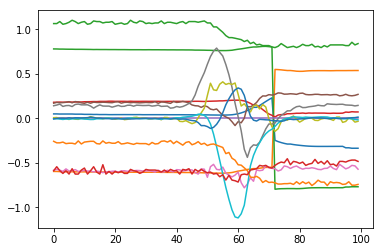

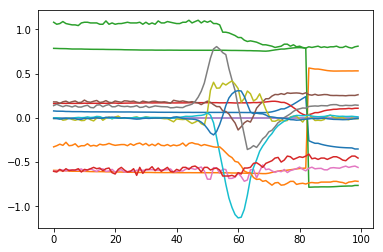

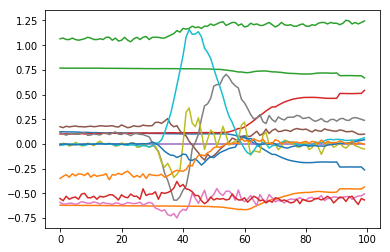

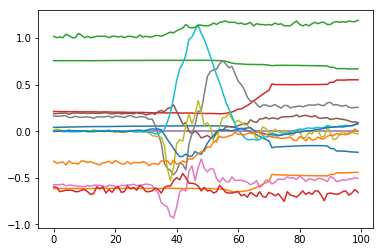

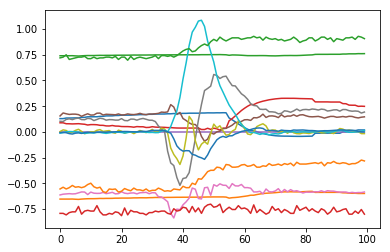

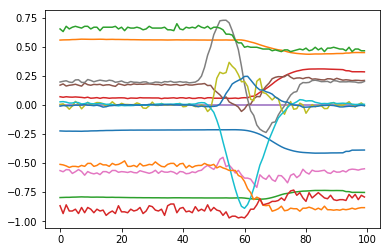

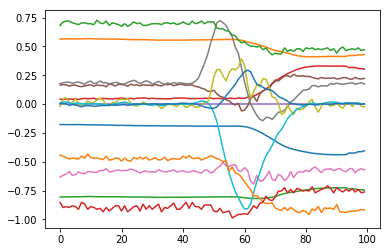

In [25]:
df, col_name_tpls = read_file("swipe_test_both.mkv")
trimed_df = trim_data(df, 10, 55)
plot_dataframe(trimed_df, col_name_tpls)
peaks = find_peaks(trimed_df, "Cywee Accelerometer Sensor_2")
print(len(peaks), ":", peaks)
cuts = normalize_cuts(cut_data(trimed_df, peaks))
print("Found cuts:", len(cuts))
plot_cuts(cuts)

In [26]:
def  learn_clisifyer(data, lables):
    print(data.shape)
    model = keras.Sequential([
        #keras.layers.Flatten(),
        keras.layers.Flatten(input_shape=cut_shape),
        keras.layers.Dense(100 * len(normalize_vector), activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(data, lables, epochs=50)
    test_loss, test_acc = model.evaluate(data, lables)

    print('Test accuracy:', test_acc)
    
    return model

    



In [27]:
def prepare_learn_set(data_frame, previous_learned_data=None):
    peaks = find_peaks(data_frame, "Cywee Accelerometer Sensor_2")
    cuts = cut_data(data_frame, peaks)
    learn_data = normalize_cuts(cuts) # Normalize
    print("DataShape:", learn_data.shape)
    
    if previous_learned_data is not None:
        learn_data = np.append(learn_data, previous_learned_data, axis=0)
    return learn_data
    
    

# Use Tensorflow to classify gestures

## Learn model


In [39]:
df, col_name_tpls = read_file("swipe_right_10_new.mkv")
trimed_df = trim_data(df, 52, 90)
learn_data_r = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("swipe_left_10.mkv")
trimed_df = trim_data(df, 10, 57)
learn_data_l = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("data/swipe_left_20.mkv")
trimed_df = trim_data(df, 15, 90)
learn_data_l = prepare_learn_set(trimed_df, learn_data_l)

df, col_name_tpls = read_file("random_noise.mkv")
trimed_df = trim_data(df, 0)
cuts = cut_data(trimed_df, [(i * 2, i*2+2) for i in range(50)])
learn_data_noise = normalize_cuts(cuts)
print("Noiseshape:", learn_data_noise.shape)
print("Learn L shape:", learn_data_l.shape)

learn_data = np.append(learn_data_noise, learn_data_l, axis=0)
learn_data = np.append(learn_data, learn_data_r, axis=0)

lables = [0]*len(learn_data_noise) + [1]*len(learn_data_l) + [2]*len(learn_data_r)

print("Learn data has shape: {}".format(learn_data.shape))
model = learn_clisifyer(learn_data, lables)


/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


DataShape: (9, 100, 9)
DataShape: (9, 100, 9)
DataShape: (18, 100, 9)
Noiseshape: (50, 100, 9)
Learn L shape: (27, 100, 9)
Learn data has shape: (86, 100, 9)
(86, 100, 9)
Epoch 1/50
86/86 [==============================] - 0s 1ms/sample - loss: 0.9568 - acc: 0.7326
Epoch 2/50
86/86 [==============================] - 0s 242us/sample - loss: 0.1466 - acc: 0.9419
Epoch 3/50
86/86 [==============================] - 0s 257us/sample - loss: 0.0760 - acc: 0.9884
Epoch 4/50
86/86 [==============================] - 0s 270us/sample - loss: 0.0470 - acc: 0.9767
Epoch 5/50
86/86 [==============================] - 0s 243us/sample - loss: 0.0182 - acc: 1.0000
Epoch 6/50
86/86 [==============================] - 0s 271us/sample - loss: 0.0121 - acc: 1.0000
Epoch 7/50
86/86 [==============================] - 0s 234us/sample - loss: 0.0076 - acc: 1.0000
Epoch 8/50
86/86 [==============================] - 0s 237us/sample - loss: 0.0020 - acc: 1.0000
Epoch 9/50
86/86 [==============================] - 0s 

# Test learned model
Test data has gestures:
Left, Left, Left, Left, Right, Right, Right, Left, Left

In [40]:
df, col_name_tpls = read_file("swipe_test_both.mkv")
trimed_df = trim_data(df, 10, 55)
test_data = prepare_learn_set(trimed_df) 
test_lables = [1, 1, 1, 1, 2, 2, 2, 1, 1]

predictions = model.predict(test_data)
print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[np.argmax(p)], 
                                         gestures[test_lables[i]], np.argmax(p) == test_lables[i]))

print('\nTest if noise will be predicted as noise')
df, col_name_tpls = read_file("data/noise_test.mkv")
trimed_df = trim_data(df, 16, 88)
learn_data_noise = prepare_learn_set(trimed_df)
noise_predictions = model.predict(learn_data_noise)
for p in noise_predictions:
    print(gestures[np.argmax(p)])

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


DataShape: (9, 100, 9)
Predicted:
0: Left should be Left -> True
1: Left should be Left -> True
2: Left should be Left -> True
3: Left should be Left -> True
4: Right should be Right -> True
5: Right should be Right -> True
6: Right should be Right -> True
7: Noise should be Left -> False
8: Left should be Left -> True

Test if noise will be predicted as noise
DataShape: (18, 100, 9)
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise


In [30]:
for p in predictions:
    print(max(p))

0.5436952
0.77576226
0.58856434
0.7556419
0.8597043
0.89517367
0.7471113
0.98969275
0.9884588


In [31]:
for p in noise_predictions:
    if np.argmax(p) != 0:
        print("classified as left or right with confidence {:.2f}%".format(max(p)*100))
    else:
        print("classified as noise,", max(p))

classified as noise, 0.9626847
classified as noise, 0.99968934
classified as noise, 0.9999993
classified as noise, 0.99999964
classified as noise, 0.9999995
classified as noise, 0.99999917
classified as noise, 0.9999995
classified as noise, 0.9999995
classified as noise, 0.9999995
classified as noise, 0.9999995
classified as noise, 0.9999995
classified as noise, 0.9999994
classified as noise, 0.99999833
classified as noise, 0.9995685
classified as noise, 0.9997317
classified as noise, 0.99997497
classified as noise, 0.99999976
classified as noise, 0.9999993


In [32]:
import sklearn.svm

In [33]:
for split in range(15,101, 15):
    print(split-15, split+10)

0 25
15 40
30 55
45 70
60 85
75 100


In [34]:
def get_features(tf_learn_data, mode="features"):
    out_data = []
    for learn_data in tf_learn_data:
        feature_vec = []
        for split in range(15,101, 15):
            cur_split = learn_data[split-15:split+10]
            for i in range(3):
                sensor_data  = cur_split[:,i]
                feature_vec.append(sensor_data.mean())
                feature_vec.append(sensor_data.max())
                feature_vec.append(sensor_data.min())
                feature_vec.append(np.median(sensor_data))
        if mode == "features":
            out_data.append(feature_vec)
        elif mode == "raw":
            out_data.append(learn_data.flatten())
    return np.array(out_data)

In [35]:
X_train = get_features(learn_data)
y = lables

X_test = test_data
y_test = test_lables


clf = sklearn.svm.SVC(gamma=1.0, decision_function_shape='ovo')
clf.fit(X_train, y) 
predictions = clf.predict(get_features(test_data))

print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[p], 
                                         gestures[y_test[i]], p == y_test[i]))

    
print(clf.predict(get_features(learn_data_noise)))

Predicted:
0: Noise should be Left -> False
1: Noise should be Left -> False
2: Noise should be Left -> False
3: Noise should be Left -> False
4: Noise should be Right -> False
5: Left should be Right -> False
6: Noise should be Right -> False
7: Noise should be Left -> False
8: Noise should be Left -> False
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [36]:
X_train.shape

(86, 72)